# 🧠 Mini GPT: Sıfırdan Decoder-Only Transformer

Bu notebook'ta sıfırdan bir GPT-style dil modeli oluşturacağız ve **Nasreddin Hoca fıkralarıyla** eğiteceğiz!

## İçindekiler

1. [Kurulum ve Veri Hazırlama](#1-kurulum-ve-veri-hazırlama)
2. [Tokenizer](#2-tokenizer)
3. [Model Mimarisi](#3-model-mimarisi)
4. [Eğitim](#4-eğitim)
5. [Metin Üretimi](#5-metin-üretimi)
6. [Sonuçlar ve Analiz](#6-sonuçlar-ve-analiz)

---
## 1. Kurulum ve Veri Hazırlama

In [1]:
# Gerekli kütüphaneler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Kullanılan cihaz: {device}")
print(f"📦 PyTorch versiyon: {torch.__version__}")

🖥️ Kullanılan cihaz: cuda
📦 PyTorch versiyon: 2.9.1+cu128


### 📚 Nasreddin Hoca Fıkraları

Mini bir dataset oluşturuyoruz. Gerçek uygulamada daha fazla veri kullanılmalı!

In [2]:
# Nasreddin Hoca fıkraları corpus'u
nasreddin_corpus = '''
Nasreddin Hoca bir gün eşeğine ters binmiş. Görenler sormuş: "Hoca, neden ters bindin?" Hoca cevap vermiş: "Ben ters binmedim, eşek ters duruyor."

Bir gün Nasreddin Hoca göle maya çalıyormuş. Görenler sormuş: "Hoca ne yapıyorsun?" Hoca: "Göle maya çalıyorum, belki tutarda yoğurt olur." demis. "Hiç gölden yoğurt olur mu?" demişler. Hoca: "Ya tutarsa?" demiş.

Nasreddin Hoca kaybettiği anahtarı sokak lambasının altında arıyormuş. Biri sormuş: "Hoca anahtarı nerede kaybettin?" Hoca: "Evde kaybettim." demiş. "Peki neden burada arıyorsun?" diye sorunca Hoca: "Burası daha aydınlık da ondan." demiş.

Hoca bir gün pazara gitmiş. Satıcı sormuş: "Hoca bu kabağı kaça alırsın?" Hoca: "Beş akçeye alırım." demiş. Satıcı: "On akçe ister." demiş. Hoca düşünmüş ve demiş ki: "Ben beş akçeye almam diyorum, sen on akçeye vermem diyorsun. Öyleyse ikimiz de almayalım."

Nasreddin Hoca komşusundan kazan ödünç almış. Bir süre sonra kazanı geri verirken içine küçük bir tencere koymuş. Komşusu sormuş: "Bu tencere ne Hoca?" Hoca: "Kazan doğurdu." demiş. Komşusu sevinerek almış. Bir süre sonra Hoca yine kazan istemiş ama geri vermemiş. Komşusu sorunca Hoca: "Kazan öldü." demiş. Komşusu itiraz edince Hoca: "Doğurduğuna inandın da öldüğüne niye inanmıyorsun?" demiş.

Bir gün Hoca hamama gitmiş. Hamamcı ona eski bir havlu ve küçük bir sabun vermiş. Hoca çıkarken bol bahşiş vermiş. Bir hafta sonra yine gitmiş. Bu sefer hamamcı en iyi havluyu ve en güzel sabunu vermiş. Ama Hoca bu sefer hiç bahşiş vermemiş. Hamamcı sormuş: "Geçen sefer az hizmet çok bahşiş, bu sefer çok hizmet hiç bahşiş. Neden Hoca?" Hoca gülmüş: "Bu seferki bahşiş geçen seferki hizmetin karşılığı, geçen seferki bahşiş de bu seferki hizmetin karşılığıydı."

Hoca bir gün yolda yürürken bir adam koşarak gelmiş ve sormuş: "Hoca, cenaze nereye gidiyor?" Hoca tabutun üzerindeki kişiye bakmış ve demiş: "Eğer mezarlığa gidiyorsa oraya, eve gidiyorsa eve."

Nasreddin Hoca minareden düşmüş. Halk etrafına toplanmış. Biri sormuş: "Hoca, düşmek nasıl bir şey?" Hoca inleyerek cevap vermiş: "Düşmek bir şey değil, asıl yere çarpmak zor."

Bir gün Hoca eşeğini kaybetmiş. Her yerde aramış bulamamış. Sonunda gözleri dolarak dua etmeye başlamış: "Ya Rabbi! Eşeğimi buldur. Bulduran kişiye eşeği vereceğim." Yanındakiler sormuş: "Hoca, eşeği bulana verirsen sana ne kalır?" Hoca: "Hiç olmazsa bulmanın sevabı kalır." demiş.

Hoca sarığını çalmışlar. Ertesi gün camide vaaz verirken demiş ki: "Ey cemaat! Dün gece sarığımı çaldılar. Bilen varsa söylesin." Cemaatten biri sormuş: "Hoca, sarığı çalan burada mı ki?" Hoca cevap vermiş: "Bilmem, ama sarığı çalan burada değilse bile sarığım burada olabilir."

Nasreddin Hoca bir gün çarşıda gezerken birisi ona bir tokat atmış. Hoca adama bakmış ve demiş: "Özür dilerim, sizi tanıyamadım." Adam şaşırmış: "Ben sana tokat attım, sen neden özür diliyorsun?" Hoca: "Çünkü siz beni başka biriyle karıştırdınız, yoksa bana tokat atmazdınız." demiş.

Bir gün Hocanın evine hırsız girmiş. Hoca uyanmış ama sesini çıkarmamış. Hırsız her yeri aramış ama bir şey bulamamış. Tam giderken Hoca arkasından seslenmiş: "Evladım, biz bu evde otuz yıldır bir şey bulamadık, sen bir gecede ne bulacaksın?"

Hoca bir gün ağaca çıkmış. Dalları keserken oturduğu dalı kesmeye başlamış. Yoldan geçen biri bağırmış: "Hoca, oturduğun dalı kesme, düşersin!" Hoca dinlememiş, dalı kesmeye devam etmiş ve düşmüş. Kalkmış, adamın peşinden koşmuş: "Sen gelecekten haber mi alıyorsun? Benim ne zaman öleceğimi de söyle." Adam: "Bilemem Hoca." demiş. Hoca: "Eşeğin kırk kere anırırsa ölürsün." demiş ve gitmiş. Adam korkuyla eşeğini saymaya başlamış.

Nasreddin Hoca bir gün yolda giderken karşısına bir adam çıkmış ve hiç tanımadığı halde tokadı yapıştırmış. Hoca şaşkınlıkla adama bakmış. Adam özür dilemiş: "Çok özür dilerim, seni arkadaşıma benzettim." Hoca düşünmüş ve demiş: "Arkadaşın da senin gibi densiz biri olmalı."

Bir gün Hoca evinde otururken kapı çalınmış. Karısı açmış, dilenci ekmek istiyormuş. Karısı yukarı çıkıp Hocaya sormuş: "Kapıda dilenci var, ekmek istiyor." Hoca: "Söyle aşağı insin." demiş. Dilenci aşağı inmiş. Hoca yine: "Söyle biraz daha aşağı insin." demiş. Dilenci mahzene inmiş. Hoca: "Şimdi söyle, bu evde ekmek yok." demiş.

Hoca pazarda koyun satıyormuş. Bir müşteri gelmiş: "Bu koyunun sütü çok mu?" Hoca: "O kadar çok ki, sabah sağarsın akşama kadar süt verir." demiş. Müşteri almış. Ertesi gün gelmiş: "Hoca bu koyundan süt çıkmıyor." Hoca sakin sakin cevap vermiş: "Ben sana süt verir dedim, sen sağmasını bilmiyorsun."

Nasreddin Hoca yolda giderken bir adam sormuş: "Hoca, şu köye gitmek için ne kadar yürümem lazım?" Hoca cevap vermemiş ve yürümeye devam etmiş. Adam biraz yürüyünce Hoca arkasından seslenmiş: "Yarım saat kadar." Adam dönmüş: "Bunu neden hemen söylemedin?" Hoca: "Nasıl yürüdüğünü bilmeden nasıl söyleyeyim?" demiş.

Hoca bir gün damdan düşmüş. Ahali toplanmış, biri sormuş: "Hoca damdan düşmek nasıl bir his?" Hoca inleyerek: "Bilmiyorum, daha önce hiç düşmemiştim." demiş.

Bir gün Hocaya sormuşlar: "Dünyanın merkezi neresidir?" Hoca ayağıyla yeri göstermiş: "İşte burasıdır." demis. "Nereden biliyorsun?" diye sorunca: "İnanmazsanız ölçün." demiş.

Nasreddin Hoca bir gece evine hırsız girdiğini duymuş. Karısına: "Ses çıkarma, hırsız ne bulursa alsın, belki biz de ondan bir şeyler kapabiliriz." demiş.
'''

print(f"📖 Corpus uzunluğu: {len(nasreddin_corpus):,} karakter")
print(f"📖 Unique karakterler: {len(set(nasreddin_corpus))}")
print(f"\n📝 İlk 500 karakter:\n{nasreddin_corpus[:500]}")

📖 Corpus uzunluğu: 5,339 karakter
📖 Unique karakterler: 56

📝 İlk 500 karakter:

Nasreddin Hoca bir gün eşeğine ters binmiş. Görenler sormuş: "Hoca, neden ters bindin?" Hoca cevap vermiş: "Ben ters binmedim, eşek ters duruyor."

Bir gün Nasreddin Hoca göle maya çalıyormuş. Görenler sormuş: "Hoca ne yapıyorsun?" Hoca: "Göle maya çalıyorum, belki tutarda yoğurt olur." demis. "Hiç gölden yoğurt olur mu?" demişler. Hoca: "Ya tutarsa?" demiş.

Nasreddin Hoca kaybettiği anahtarı sokak lambasının altında arıyormuş. Biri sormuş: "Hoca anahtarı nerede kaybettin?" Hoca: "Evde kaybett


---
## 2. Tokenizer

Basitlik için **karakter seviyesi** (character-level) tokenization kullanacağız.

Gerçek GPT modelleri BPE (Byte Pair Encoding) kullanır, ama bu eğitim için char-level yeterli.

In [3]:
class CharTokenizer:
    """
    Karakter seviyesi tokenizer.
    
    Her unique karakter bir token'a karşılık gelir.
    """
    
    def __init__(self, text):
        # Unique karakterleri bul ve sırala
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        
        # Karakter <-> ID mapping
        self.char_to_id = {ch: i for i, ch in enumerate(self.chars)}
        self.id_to_char = {i: ch for i, ch in enumerate(self.chars)}
        
    def encode(self, text):
        """Metni token ID listesine çevir"""
        return [self.char_to_id[ch] for ch in text]
    
    def decode(self, ids):
        """Token ID listesini metne çevir"""
        return ''.join([self.id_to_char[i] for i in ids])

# Tokenizer oluştur
tokenizer = CharTokenizer(nasreddin_corpus)

print(f"📊 Vocab boyutu: {tokenizer.vocab_size}")
print(f"\n🔤 Karakterler: {''.join(tokenizer.chars[:50])}...")
print(f"\n✅ Test:")
test_text = "Nasreddin Hoca"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"   Orijinal: {test_text}")
print(f"   Encoded:  {encoded}")
print(f"   Decoded:  {decoded}")

📊 Vocab boyutu: 56

🔤 Karakterler: 
 !",.:?ABCDEGHKMNOPRSTYabcdefghiklmnoprstuvyzÇÖçö...

✅ Test:
   Orijinal: Nasreddin Hoca
   Encoded:  [17, 24, 40, 39, 28, 27, 27, 32, 36, 1, 14, 37, 26, 24]
   Decoded:  Nasreddin Hoca


### 📦 Dataset Sınıfı

In [4]:
class TextDataset(Dataset):
    """
    Dil modelleme için dataset.
    
    Her örnek:
    - input: [t0, t1, t2, ..., tn-1]
    - target: [t1, t2, t3, ..., tn] (bir kaydırılmış)
    """
    
    def __init__(self, text, tokenizer, seq_len):
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        
        # Tüm metni tokenize et
        self.data = torch.tensor(tokenizer.encode(text), dtype=torch.long)
        
    def __len__(self):
        # Her başlangıç pozisyonu bir örnek
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        # Input: [idx : idx + seq_len]
        # Target: [idx + 1 : idx + seq_len + 1]
        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + 1 : idx + self.seq_len + 1]
        return x, y

# Dataset ve DataLoader
SEQ_LEN = 128
BATCH_SIZE = 32

dataset = TextDataset(nasreddin_corpus, tokenizer, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"📊 Dataset boyutu: {len(dataset):,} örnek")
print(f"📊 Batch sayısı: {len(dataloader)}")

# Örnek batch
x_sample, y_sample = next(iter(dataloader))
print(f"\n📦 Örnek batch:")
print(f"   x shape: {x_sample.shape}")
print(f"   y shape: {y_sample.shape}")
print(f"\n   İlk örnek (ilk 50 karakter):")
print(f"   Input:  '{tokenizer.decode(x_sample[0][:50].tolist())}'")
print(f"   Target: '{tokenizer.decode(y_sample[0][:50].tolist())}'")

📊 Dataset boyutu: 5,211 örnek
📊 Batch sayısı: 163

📦 Örnek batch:
   x shape: torch.Size([32, 128])
   y shape: torch.Size([32, 128])

   İlk örnek (ilk 50 karakter):
   Input:  'zan ödünç almış. Bir süre sonra kazanı geri verirk'
   Target: 'an ödünç almış. Bir süre sonra kazanı geri verirke'


---
## 3. Model Mimarisi

Şimdi GPT'nin tüm bileşenlerini sıfırdan implement edeceğiz.

### 3.1 Model Konfigürasyonu

In [5]:
@dataclass
class GPTConfig:
    """GPT model konfigürasyonu"""
    vocab_size: int = 100        # Tokenizer'dan gelecek
    max_seq_len: int = 128       # Maksimum sequence uzunluğu
    d_model: int = 192           # Embedding boyutu
    num_heads: int = 6           # Attention head sayısı
    num_layers: int = 6          # Transformer block sayısı
    d_ff: int = 768              # FFN iç boyutu (4 * d_model)
    dropout: float = 0.1         # Dropout oranı
    
# Config oluştur
config = GPTConfig(
    vocab_size=tokenizer.vocab_size,
    max_seq_len=SEQ_LEN,
    d_model=192,
    num_heads=6,
    num_layers=6,
    d_ff=768,
    dropout=0.1
)

print("⚙️ Model Konfigürasyonu:")
print(f"   vocab_size:   {config.vocab_size}")
print(f"   max_seq_len:  {config.max_seq_len}")
print(f"   d_model:      {config.d_model}")
print(f"   num_heads:    {config.num_heads}")
print(f"   num_layers:   {config.num_layers}")
print(f"   d_ff:         {config.d_ff}")
print(f"   d_head:       {config.d_model // config.num_heads}")

⚙️ Model Konfigürasyonu:
   vocab_size:   56
   max_seq_len:  128
   d_model:      192
   num_heads:    6
   num_layers:   6
   d_ff:         768
   d_head:       32


### 3.2 Causal Self-Attention

GPT'nin kalbi! Her token sadece **önceki tokenlere** bakabilir.

In [6]:
class CausalSelfAttention(nn.Module):
    """
    Causal (Masked) Self-Attention
    
    Her token sadece kendinden önceki tokenlere attention uygulayabilir.
    Bu, autoregressive generation için gereklidir.
    """
    
    def __init__(self, config):
        super().__init__()
        
        assert config.d_model % config.num_heads == 0, "d_model, num_heads'e bölünebilmeli!"
        
        self.num_heads = config.num_heads
        self.d_head = config.d_model // config.num_heads
        self.d_model = config.d_model
        
        # Q, K, V projeksiyonları tek bir linear layer'da (verimlilik için)
        self.qkv_proj = nn.Linear(config.d_model, 3 * config.d_model)
        
        # Output projeksiyonu
        self.out_proj = nn.Linear(config.d_model, config.d_model)
        
        # Dropout
        self.attn_dropout = nn.Dropout(config.dropout)
        self.out_dropout = nn.Dropout(config.dropout)
        
        # Causal mask: üst üçgen matris (bakılmaması gereken pozisyonlar)
        # Bu mask eğitim sırasında değişmez, buffer olarak kaydediyoruz
        mask = torch.triu(
            torch.ones(config.max_seq_len, config.max_seq_len), 
            diagonal=1
        ).bool()
        self.register_buffer('causal_mask', mask)
        
    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, d_model]
        Returns:
            output: [batch_size, seq_len, d_model]
        """
        B, T, C = x.shape
        
        # Q, K, V hesapla (tek seferde, sonra ayır)
        qkv = self.qkv_proj(x)  # [B, T, 3*d_model]
        q, k, v = qkv.chunk(3, dim=-1)  # Her biri [B, T, d_model]
        
        # Head'lere ayır: [B, T, d_model] -> [B, num_heads, T, d_head]
        q = q.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.d_head).transpose(1, 2)
        
        # Attention skorları: Q @ K^T / sqrt(d_head)
        # [B, heads, T, d_head] @ [B, heads, d_head, T] = [B, heads, T, T]
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)
        
        # Causal mask uygula (gelecek tokenler -inf olur)
        scores = scores.masked_fill(self.causal_mask[:T, :T], float('-inf'))
        
        # Softmax (satır bazında)
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        
        # Attention output: weights @ V
        # [B, heads, T, T] @ [B, heads, T, d_head] = [B, heads, T, d_head]
        attn_output = torch.matmul(attn_weights, v)
        
        # Head'leri birleştir: [B, heads, T, d_head] -> [B, T, d_model]
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        
        # Output projeksiyon
        output = self.out_dropout(self.out_proj(attn_output))
        
        return output

# Test
attn = CausalSelfAttention(config)
x_test = torch.randn(2, 32, config.d_model)
out_test = attn(x_test)
print(f"✅ CausalSelfAttention test:")
print(f"   Input:  {x_test.shape}")
print(f"   Output: {out_test.shape}")

✅ CausalSelfAttention test:
   Input:  torch.Size([2, 32, 192])
   Output: torch.Size([2, 32, 192])


### 3.3 Feed-Forward Network (MLP)

İki katmanlı MLP. GELU aktivasyonu kullanıyoruz (modern standart).

In [7]:
class MLP(nn.Module):
    """
    Position-wise Feed-Forward Network
    
    Yapısı: Linear -> GELU -> Linear -> Dropout
    
    d_model -> d_ff -> d_model (genişlet, daralt)
    """
    
    def __init__(self, config):
        super().__init__()
        
        self.fc1 = nn.Linear(config.d_model, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, config.d_model)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, d_model]
        Returns:
            output: [batch_size, seq_len, d_model]
        """
        x = self.fc1(x)       # [B, T, d_ff]
        x = self.act(x)        # GELU aktivasyon
        x = self.fc2(x)       # [B, T, d_model]
        x = self.dropout(x)
        return x

# Test
mlp = MLP(config)
out_mlp = mlp(x_test)
print(f"✅ MLP test: {x_test.shape} -> {out_mlp.shape}")

✅ MLP test: torch.Size([2, 32, 192]) -> torch.Size([2, 32, 192])


### 3.4 GPT Block (Pre-LayerNorm)

Modern GPT'ler **Pre-LN** kullanır: LayerNorm önce gelir.

In [8]:
class GPTBlock(nn.Module):
    """
    Tek bir GPT Transformer bloğu (Pre-LayerNorm versiyonu)
    
    Yapısı:
    x -> LN -> Attention -> + -> LN -> MLP -> +
    |__________________________|            |
                               |____________|
            (residual connections)
    """
    
    def __init__(self, config):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(config.d_model)
        self.attn = CausalSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.mlp = MLP(config)
        
    def forward(self, x):
        """
        Pre-LN: LayerNorm sublayer'dan ÖNCE uygulanır
        
        Bu, residual path'i temiz tutar ve gradient flow'u iyileştirir.
        """
        # Attention block with residual
        x = x + self.attn(self.ln1(x))
        
        # MLP block with residual  
        x = x + self.mlp(self.ln2(x))
        
        return x

# Test
block = GPTBlock(config)
out_block = block(x_test)
print(f"✅ GPTBlock test: {x_test.shape} -> {out_block.shape}")

✅ GPTBlock test: torch.Size([2, 32, 192]) -> torch.Size([2, 32, 192])


### 3.5 Tam GPT Modeli

Tüm parçaları birleştiriyoruz!

In [9]:
class MiniGPT(nn.Module):
    """
    Mini GPT - Decoder-Only Transformer
    
    Bileşenler:
    1. Token Embedding
    2. Position Embedding (learned)
    3. N x GPT Block
    4. Final LayerNorm
    5. Output Head (weight tying ile)
    """
    
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Token embedding: vocab_size -> d_model
        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        
        # Position embedding (learned, sinusoidal değil)
        self.pos_emb = nn.Embedding(config.max_seq_len, config.d_model)
        
        # Embedding dropout
        self.drop = nn.Dropout(config.dropout)
        
        # GPT blocks
        self.blocks = nn.ModuleList([
            GPTBlock(config) for _ in range(config.num_layers)
        ])
        
        # Final LayerNorm
        self.ln_f = nn.LayerNorm(config.d_model)
        
        # Output head: d_model -> vocab_size
        self.head = nn.Linear(config.d_model, config.vocab_size, bias=False)
        
        # ⭐ Weight Tying: embedding ve output head ağırlıklarını paylaş
        # Bu hem parametre tasarrufu sağlar hem de performansı artırır
        self.head.weight = self.token_emb.weight
        
        # Ağırlık başlatma
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Ağırlıkları GPT-2 tarzı başlat"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, idx, targets=None):
        """
        Args:
            idx: Token ID'leri [batch_size, seq_len]
            targets: Hedef token ID'leri (eğitim için) [batch_size, seq_len]
            
        Returns:
            logits: [batch_size, seq_len, vocab_size]
            loss: Cross-entropy loss (targets verilmişse)
        """
        B, T = idx.shape
        
        # Token embedding
        tok_emb = self.token_emb(idx)  # [B, T, d_model]
        
        # Position embedding
        positions = torch.arange(T, device=idx.device)  # [T]
        pos_emb = self.pos_emb(positions)  # [T, d_model]
        
        # Embedding'leri topla
        x = self.drop(tok_emb + pos_emb)  # [B, T, d_model]
        
        # GPT blocks
        for block in self.blocks:
            x = block(x)
            
        # Final LayerNorm
        x = self.ln_f(x)  # [B, T, d_model]
        
        # Output projection (logits)
        logits = self.head(x)  # [B, T, vocab_size]
        
        # Loss hesapla (eğer targets verilmişse)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),  # [B*T, vocab_size]
                targets.view(-1)                    # [B*T]
            )
            
        return logits, loss
    
    def get_num_params(self):
        """Toplam parametre sayısı (weight tying hariç)"""
        n_params = sum(p.numel() for p in self.parameters())
        # Weight tying nedeniyle embedding'i bir kez sayıyoruz
        return n_params

# Model oluştur
model = MiniGPT(config).to(device)

print("🤖 Mini GPT Modeli Oluşturuldu!")
print(f"\n📊 Model İstatistikleri:")
print(f"   Toplam parametre: {model.get_num_params():,}")
print(f"   Yaklaşık: {model.get_num_params() / 1e6:.2f}M parametre")

# Test forward pass
test_input = torch.randint(0, config.vocab_size, (2, 32)).to(device)
test_target = torch.randint(0, config.vocab_size, (2, 32)).to(device)
logits, loss = model(test_input, test_target)

print(f"\n✅ Forward pass test:")
print(f"   Input shape:  {test_input.shape}")
print(f"   Logits shape: {logits.shape}")
print(f"   Loss: {loss.item():.4f}")

🤖 Mini GPT Modeli Oluşturuldu!

📊 Model İstatistikleri:
   Toplam parametre: 2,704,896
   Yaklaşık: 2.70M parametre

✅ Forward pass test:
   Input shape:  torch.Size([2, 32])
   Logits shape: torch.Size([2, 32, 56])
   Loss: 4.0638


---
## 4. Eğitim

Şimdi modelimizi Nasreddin Hoca fıkralarıyla eğiteceğiz!

In [10]:
# Eğitim parametreleri
LEARNING_RATE = 3e-4
NUM_EPOCHS = 100
EVAL_INTERVAL = 10

# Optimizer (AdamW - weight decay ile)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (cosine annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=NUM_EPOCHS, eta_min=LEARNING_RATE / 10
)

print(f"⚙️ Eğitim Ayarları:")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Optimizer: AdamW")

⚙️ Eğitim Ayarları:
   Learning rate: 0.0003
   Epochs: 100
   Batch size: 32
   Optimizer: AdamW


In [11]:
def train_epoch(model, dataloader, optimizer, device):
    """Tek bir epoch eğitim"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        
        # Forward pass
        logits, loss = model(x, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (stabilite için)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
        
    return total_loss / num_batches

@torch.no_grad()
def evaluate(model, dataloader, device):
    """Model değerlendirme"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)
        total_loss += loss.item()
        num_batches += 1
        
    return total_loss / num_batches

In [12]:
# Eğitim döngüsü
print("🚀 Eğitim başlıyor...\n")

train_losses = []
best_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    # Eğitim
    train_loss = train_epoch(model, dataloader, optimizer, device)
    train_losses.append(train_loss)
    
    # Learning rate güncelle
    scheduler.step()
    
    # En iyi modeli kaydet
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    # İlerleme raporu
    if epoch % EVAL_INTERVAL == 0 or epoch == 1:
        perplexity = math.exp(train_loss)
        lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch:3d}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | Perplexity: {perplexity:.2f} | LR: {lr:.2e}")

print(f"\n✅ Eğitim tamamlandı!")
print(f"   En iyi loss: {best_loss:.4f}")
print(f"   En iyi perplexity: {math.exp(best_loss):.2f}")

🚀 Eğitim başlıyor...

Epoch   1/100 | Loss: 2.3525 | Perplexity: 10.51 | LR: 3.00e-04
Epoch  10/100 | Loss: 0.1042 | Perplexity: 1.11 | LR: 2.93e-04
Epoch  20/100 | Loss: 0.0703 | Perplexity: 1.07 | LR: 2.74e-04
Epoch  30/100 | Loss: 0.0607 | Perplexity: 1.06 | LR: 2.44e-04
Epoch  40/100 | Loss: 0.0551 | Perplexity: 1.06 | LR: 2.07e-04
Epoch  50/100 | Loss: 0.0521 | Perplexity: 1.05 | LR: 1.65e-04
Epoch  60/100 | Loss: 0.0496 | Perplexity: 1.05 | LR: 1.23e-04
Epoch  70/100 | Loss: 0.0480 | Perplexity: 1.05 | LR: 8.56e-05
Epoch  80/100 | Loss: 0.0467 | Perplexity: 1.05 | LR: 5.58e-05
Epoch  90/100 | Loss: 0.0457 | Perplexity: 1.05 | LR: 3.66e-05
Epoch 100/100 | Loss: 0.0452 | Perplexity: 1.05 | LR: 3.00e-05

✅ Eğitim tamamlandı!
   En iyi loss: 0.0452
   En iyi perplexity: 1.05


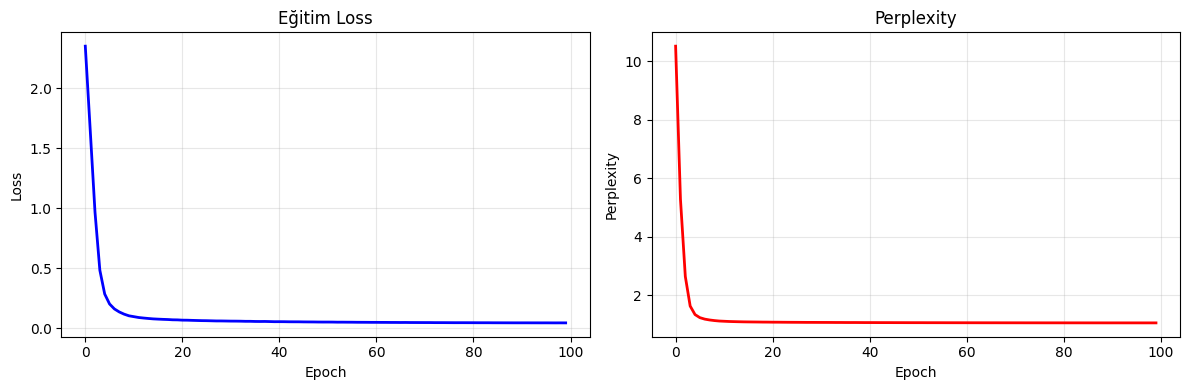

In [13]:
# Eğitim grafiği
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
perplexities = [math.exp(l) for l in train_losses]
plt.plot(perplexities, 'r-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. Metin Üretimi

Farklı sampling stratejileri ile metin üretimi.

In [14]:
@torch.no_grad()
def generate(
    model, 
    tokenizer,
    prompt="Nasreddin Hoca",
    max_tokens=200,
    temperature=1.0,
    top_k=None,
    top_p=None,
    device='cpu'
):
    """
    Metin üretimi (autoregressive generation)
    
    Args:
        model: Eğitilmiş GPT modeli
        tokenizer: Tokenizer
        prompt: Başlangıç metni
        max_tokens: Üretilecek maksimum token sayısı
        temperature: Sampling temperature (1.0 = normal)
        top_k: Top-k sampling (None = kapalı)
        top_p: Nucleus sampling (None = kapalı)
        device: Cihaz
    """
    model.eval()
    
    # Prompt'u tokenize et
    tokens = tokenizer.encode(prompt)
    tokens = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)
    
    # Token token üret
    for _ in range(max_tokens):
        # Maksimum context uzunluğunu kontrol et
        tokens_cond = tokens[:, -model.config.max_seq_len:]
        
        # Forward pass
        logits, _ = model(tokens_cond)
        
        # Son pozisyonun logits'i
        logits = logits[:, -1, :]  # [1, vocab_size]
        
        # Temperature uygula
        logits = logits / temperature
        
        # Top-k sampling
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float('-inf')
            
        # Top-p (nucleus) sampling
        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumsum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            
            # p'yi aşan tokenleri maskele
            sorted_indices_to_remove = cumsum_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = False
            
            indices_to_remove = sorted_indices_to_remove.scatter(
                1, sorted_indices, sorted_indices_to_remove
            )
            logits[indices_to_remove] = float('-inf')
        
        # Olasılıkları hesapla
        probs = F.softmax(logits, dim=-1)
        
        # Örnekle
        next_token = torch.multinomial(probs, num_samples=1)
        
        # Token'ı ekle
        tokens = torch.cat([tokens, next_token], dim=1)
        
    # Decode et
    generated_text = tokenizer.decode(tokens[0].tolist())
    
    return generated_text

print("✅ Generate fonksiyonu tanımlandı")

✅ Generate fonksiyonu tanımlandı


In [16]:
# En iyi modeli yükle
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

print("🎭 Metin Üretimi Örnekleri\n")
print("=" * 60)

🎭 Metin Üretimi Örnekleri



In [18]:
# Örnek 1: Greedy (temperature çok düşük)
print("\n📝 Örnek 1: Greedy-like (temperature=0.3)")
print("-" * 60)
text = generate(
    model, tokenizer, 
    prompt="Nasreddin Hoca bir gün",
    max_tokens=150,
    temperature=0.3,
    device=device
)
print(text)


📝 Örnek 1: Greedy-like (temperature=0.3)
------------------------------------------------------------
Nasreddin Hoca bir gün çarşıda gezerken birisi ona bir tokat atmış. Hoca adama bakmış ve demiş: "Özür dilerim, sizi tanıyamadım." Adam şaşırmış: "Ben sana tokat attım, sen 


In [19]:
# Örnek 2: Normal sampling
print("\n📝 Örnek 2: Normal sampling (temperature=0.8)")
print("-" * 60)
text = generate(
    model, tokenizer,
    prompt="Hoca pazara gitmiş",
    max_tokens=150,
    temperature=0.8,
    device=device
)
print(text)


📝 Örnek 2: Normal sampling (temperature=0.8)
------------------------------------------------------------
Hoca pazara gitmiş. Satıcı sormuş: "Hoca bu kabağı kaça alırsın?" Hoca: "Beş akçeye alırım." demiş. Satıcı: "On akçe ister." demiş. Hoca düşünmüş ve demiş ki: "Ben beş 


In [20]:
# Örnek 3: Top-k sampling
print("\n📝 Örnek 3: Top-k sampling (k=40, temperature=0.9)")
print("-" * 60)
text = generate(
    model, tokenizer,
    prompt="Bir gün Hoca",
    max_tokens=150,
    temperature=0.9,
    top_k=40,
    device=device
)
print(text)


📝 Örnek 3: Top-k sampling (k=40, temperature=0.9)
------------------------------------------------------------
Bir gün Hocanın evine hırsız girmiş. Hoca uyanmış ama sesini çıkarmamış. Hırsız her yeri aramış ama bir şey bulamamış. Tam giderken Hoca arkasından seslenmiş: "Ev


In [21]:
# Örnek 4: Nucleus (top-p) sampling
print("\n📝 Örnek 4: Nucleus sampling (p=0.9, temperature=0.8)")
print("-" * 60)
text = generate(
    model, tokenizer,
    prompt="Komşusu Hocaya sormuş",
    max_tokens=150,
    temperature=0.8,
    top_p=0.9,
    device=device
)
print(text)


📝 Örnek 4: Nucleus sampling (p=0.9, temperature=0.8)
------------------------------------------------------------
Komşusu Hocaya sormuş: "Kapıda dilenci var, ekmek istiyor." Hoca: "Söyle aşağı insin." demiş. Dilenci aşağı inmiş. Hoca yine: "Söyle biraz daha aşağı insin." demiş. Dilenc


In [22]:
# İnteraktif deneme
print("\n" + "=" * 60)
print("🎮 Kendi prompt'unuzu deneyin!")
print("=" * 60)

custom_prompt = "Hoca eşeğini"  # İstediğiniz prompt'u yazın

text = generate(
    model, tokenizer,
    prompt=custom_prompt,
    max_tokens=200,
    temperature=0.7,
    top_p=0.9,
    device=device
)
print(f"\nPrompt: '{custom_prompt}'")
print("-" * 60)
print(text)


🎮 Kendi prompt'unuzu deneyin!

Prompt: 'Hoca eşeğini'
------------------------------------------------------------
Hoca eşeğini kaybetmiş. Her yerde aramış bulamamış. Sonunda gözleri dolarak dua etmeye başlamış: "Ya Rabbi! Eşeğimi buldur. Bulduran kişiye eşeği vereceğim." Yanındakiler sormuş: "Hoca, eşeği bulana verirsen sana


---
## 6. Sonuçlar ve Analiz

In [23]:
# Model özeti
print("📊 MODEL ÖZETİ")
print("=" * 60)
print(f"\n🏗️ Mimari:")
print(f"   Tip: Decoder-Only Transformer (GPT-style)")
print(f"   Layer sayısı: {config.num_layers}")
print(f"   Head sayısı: {config.num_heads}")
print(f"   d_model: {config.d_model}")
print(f"   d_ff: {config.d_ff}")
print(f"   Parametre sayısı: {model.get_num_params():,}")

print(f"\n📚 Veri:")
print(f"   Dataset: Nasreddin Hoca fıkraları")
print(f"   Corpus boyutu: {len(nasreddin_corpus):,} karakter")
print(f"   Vocab boyutu: {tokenizer.vocab_size}")
print(f"   Sequence uzunluğu: {SEQ_LEN}")

print(f"\n📈 Eğitim:")
print(f"   Final loss: {train_losses[-1]:.4f}")
print(f"   Final perplexity: {math.exp(train_losses[-1]):.2f}")
print(f"   En iyi loss: {best_loss:.4f}")

📊 MODEL ÖZETİ

🏗️ Mimari:
   Tip: Decoder-Only Transformer (GPT-style)
   Layer sayısı: 6
   Head sayısı: 6
   d_model: 192
   d_ff: 768
   Parametre sayısı: 2,704,896

📚 Veri:
   Dataset: Nasreddin Hoca fıkraları
   Corpus boyutu: 5,339 karakter
   Vocab boyutu: 56
   Sequence uzunluğu: 128

📈 Eğitim:
   Final loss: 0.0452
   Final perplexity: 1.05
   En iyi loss: 0.0452


### 💡 Önemli Gözlemler

1. **Küçük dataset = Overfitting**: Model ezberlemeye başlayabilir. Daha fazla veri ile daha iyi sonuç alınır.

2. **Character-level vs Subword**: BPE tokenization daha verimli olurdu, ama char-level anlaşılması kolay.

3. **Temperature etkisi**:
   - Düşük (0.3): Tekrarlayan, güvenli çıktılar
   - Normal (0.7-0.9): Dengeli ve okunabilir
   - Yüksek (>1.5): Yaratıcı ama anlamsızlaşabilir

4. **Top-p vs Top-k**:
   - Top-p dinamik (dağılıma göre ayarlanır)
   - Top-k sabit (her zaman k token)

---
## 🎓 Sonuç

Bu notebook'ta sıfırdan bir GPT modeli inşa ettik:

✅ Causal Self-Attention implementasyonu  
✅ Pre-LayerNorm GPT Block  
✅ Weight Tying  
✅ Çeşitli sampling stratejileri  
✅ Nasreddin Hoca fıkralarıyla eğitim  

### 📚 Sonraki Adımlar

- Daha büyük dataset ile eğitim
- BPE tokenization ekleme
- Flash Attention optimizasyonu
- Fine-tuning denemeler